In [ ]:
# Install dependencies
! pip install ta
! pip install tensorflow
! pip install keras

In [1]:
# Libraries for Data Analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import timedelta

# Machine learning Library
from sklearn.preprocessing import RobustScaler

# Library for Performing Technical Analysis
import ta

# Tensorflow 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Loading the data
data_frame = pd.read_csv("SPY_historical_data.csv")

In [2]:
data_frame['Date'] = pd.to_datetime(data_frame.Date)
data_frame.set_index('Date', inplace=True)
data_frame.dropna(inplace=True)

data_frame = ta.add_all_ta_features(data_frame, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

data_frame.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis = 1, inplace = True)

data_frame = data_frame.tail(1000)

close_scaler = RobustScaler()

close_scaler.fit(data_frame[['Close']])

scaler = RobustScaler()

data_frame = pd.DataFrame(scaler.fit_transform(data_frame), columns = data_frame.columns, index = data_frame.index)

C:\Users\ahadk\anaconda3\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\Users\ahadk\anaconda3\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [9]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
  

def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          
            
def validator(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=data_frame.index, columns=[data_frame.columns[0]])

    for i in range(n_per_in, len(data_frame)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = data_frame[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [26]:
days_learn = 20

days_predict = 5

features = data_frame.shape[1]

x,y = split_sequence(data_frame.to_numpy(), days_learn, days_predict)

In [27]:
model = Sequential()

activ = "tanh"

model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(days_learn, features)))

layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)

model.add(LSTM(60, activation=activ))

model.add(Dense(days_predict))

model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

res = model.fit(x, y, epochs=500, batch_size=128, validation_split=0.1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 20, 90)            59040     
_________________________________________________________________
lstm_16 (LSTM)               (None, 20, 30)            14520     
_________________________________________________________________
lstm_17 (LSTM)               (None, 60)                21840     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 305       
Total params: 95,705
Trainable params: 95,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
7/7 [==============================] - 1s 192ms/step - loss: 0.2159 - accuracy: 0.2551 - val_loss: 0.4019 - val_accuracy: 0.1531
Epoch 2/500
7/7 [==============================] - 0s 41ms/step - loss: 0.0668 - accuracy: 0.2153 - val_los

Epoch 53/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0023 - accuracy: 0.4282 - val_loss: 0.1443 - val_accuracy: 0.1735
Epoch 54/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0023 - accuracy: 0.4260 - val_loss: 0.1442 - val_accuracy: 0.2041
Epoch 55/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0022 - accuracy: 0.4305 - val_loss: 0.1458 - val_accuracy: 0.2143
Epoch 56/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0022 - accuracy: 0.4305 - val_loss: 0.1530 - val_accuracy: 0.2143
Epoch 57/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0022 - accuracy: 0.4339 - val_loss: 0.1416 - val_accuracy: 0.2245
Epoch 58/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0022 - accuracy: 0.4385 - val_loss: 0.1510 - val_accuracy: 0.1939
Epoch 59/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0022 - accuracy: 0.4282 - val_loss: 0.1455 - val_accuracy: 0.2449
Epoch 60/500


7/7 [==============================] - 0s 39ms/step - loss: 0.0018 - accuracy: 0.4670 - val_loss: 0.1562 - val_accuracy: 0.1531
Epoch 112/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0018 - accuracy: 0.4818 - val_loss: 0.1528 - val_accuracy: 0.1531
Epoch 113/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0018 - accuracy: 0.4670 - val_loss: 0.1471 - val_accuracy: 0.1939
Epoch 114/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0017 - accuracy: 0.4772 - val_loss: 0.1526 - val_accuracy: 0.1531
Epoch 115/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0017 - accuracy: 0.4749 - val_loss: 0.1516 - val_accuracy: 0.2143
Epoch 116/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0017 - accuracy: 0.4806 - val_loss: 0.1469 - val_accuracy: 0.1939
Epoch 117/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0017 - accuracy: 0.4670 - val_loss: 0.1553 - val_accuracy: 0.1735
Epoch 118/500
7/7 [=

Epoch 169/500
7/7 [==============================] - 0s 42ms/step - loss: 0.0015 - accuracy: 0.5182 - val_loss: 0.1523 - val_accuracy: 0.2143
Epoch 170/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0015 - accuracy: 0.5080 - val_loss: 0.1532 - val_accuracy: 0.2143
Epoch 171/500
7/7 [==============================] - 0s 39ms/step - loss: 0.0015 - accuracy: 0.5194 - val_loss: 0.1497 - val_accuracy: 0.2041
Epoch 172/500
7/7 [==============================] - 0s 42ms/step - loss: 0.0015 - accuracy: 0.5125 - val_loss: 0.1546 - val_accuracy: 0.2143
Epoch 173/500
7/7 [==============================] - 0s 41ms/step - loss: 0.0014 - accuracy: 0.5068 - val_loss: 0.1571 - val_accuracy: 0.2041
Epoch 174/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0014 - accuracy: 0.5137 - val_loss: 0.1510 - val_accuracy: 0.2347
Epoch 175/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0015 - accuracy: 0.5159 - val_loss: 0.1510 - val_accuracy: 0.2143
Epoch 

Epoch 227/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0014 - accuracy: 0.5137 - val_loss: 0.1594 - val_accuracy: 0.1327
Epoch 228/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0013 - accuracy: 0.5148 - val_loss: 0.1680 - val_accuracy: 0.1429
Epoch 229/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0013 - accuracy: 0.5251 - val_loss: 0.1664 - val_accuracy: 0.1735
Epoch 230/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0013 - accuracy: 0.5182 - val_loss: 0.1636 - val_accuracy: 0.1327
Epoch 231/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0012 - accuracy: 0.5410 - val_loss: 0.1636 - val_accuracy: 0.1429
Epoch 232/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0012 - accuracy: 0.5068 - val_loss: 0.1669 - val_accuracy: 0.1735
Epoch 233/500
7/7 [==============================] - 0s 40ms/step - loss: 0.0012 - accuracy: 0.5308 - val_loss: 0.1680 - val_accuracy: 0.1735
Epoch 

7/7 [==============================] - 0s 41ms/step - loss: 8.7481e-04 - accuracy: 0.5478 - val_loss: 0.1775 - val_accuracy: 0.1735
Epoch 285/500
7/7 [==============================] - 0s 40ms/step - loss: 8.4125e-04 - accuracy: 0.5376 - val_loss: 0.1771 - val_accuracy: 0.1531
Epoch 286/500
7/7 [==============================] - 0s 40ms/step - loss: 8.2771e-04 - accuracy: 0.5638 - val_loss: 0.1831 - val_accuracy: 0.1122
Epoch 287/500
7/7 [==============================] - 0s 40ms/step - loss: 8.3605e-04 - accuracy: 0.5444 - val_loss: 0.1845 - val_accuracy: 0.1531
Epoch 288/500
7/7 [==============================] - 0s 40ms/step - loss: 8.7425e-04 - accuracy: 0.5296 - val_loss: 0.1762 - val_accuracy: 0.1531
Epoch 289/500
7/7 [==============================] - 0s 40ms/step - loss: 8.1889e-04 - accuracy: 0.5524 - val_loss: 0.1771 - val_accuracy: 0.1735
Epoch 290/500
7/7 [==============================] - 0s 41ms/step - loss: 8.1564e-04 - accuracy: 0.5456 - val_loss: 0.1788 - val_accuracy:

7/7 [==============================] - 0s 41ms/step - loss: 6.5856e-04 - accuracy: 0.5490 - val_loss: 0.1928 - val_accuracy: 0.1633
Epoch 341/500
7/7 [==============================] - 0s 40ms/step - loss: 6.8285e-04 - accuracy: 0.5433 - val_loss: 0.1923 - val_accuracy: 0.1633
Epoch 342/500
7/7 [==============================] - 0s 40ms/step - loss: 6.7488e-04 - accuracy: 0.5387 - val_loss: 0.1879 - val_accuracy: 0.1837
Epoch 343/500
7/7 [==============================] - 0s 40ms/step - loss: 6.7581e-04 - accuracy: 0.5615 - val_loss: 0.1967 - val_accuracy: 0.1735
Epoch 344/500
7/7 [==============================] - 0s 40ms/step - loss: 6.6976e-04 - accuracy: 0.5524 - val_loss: 0.1934 - val_accuracy: 0.1735
Epoch 345/500
7/7 [==============================] - 0s 40ms/step - loss: 6.6726e-04 - accuracy: 0.5615 - val_loss: 0.1898 - val_accuracy: 0.1735
Epoch 346/500
7/7 [==============================] - 0s 40ms/step - loss: 6.4406e-04 - accuracy: 0.5581 - val_loss: 0.1943 - val_accuracy:

7/7 [==============================] - 0s 40ms/step - loss: 4.8866e-04 - accuracy: 0.5786 - val_loss: 0.2040 - val_accuracy: 0.1735
Epoch 397/500
7/7 [==============================] - 0s 40ms/step - loss: 4.7679e-04 - accuracy: 0.5763 - val_loss: 0.2067 - val_accuracy: 0.1939
Epoch 398/500
7/7 [==============================] - 0s 45ms/step - loss: 4.8945e-04 - accuracy: 0.5695 - val_loss: 0.2094 - val_accuracy: 0.1837
Epoch 399/500
7/7 [==============================] - 0s 45ms/step - loss: 4.7879e-04 - accuracy: 0.5740 - val_loss: 0.2076 - val_accuracy: 0.1837
Epoch 400/500
7/7 [==============================] - 0s 45ms/step - loss: 4.7479e-04 - accuracy: 0.5683 - val_loss: 0.2047 - val_accuracy: 0.1633
Epoch 401/500
7/7 [==============================] - 0s 45ms/step - loss: 4.7847e-04 - accuracy: 0.5877 - val_loss: 0.2069 - val_accuracy: 0.1633
Epoch 402/500
7/7 [==============================] - 0s 42ms/step - loss: 5.0080e-04 - accuracy: 0.5809 - val_loss: 0.2051 - val_accuracy:

7/7 [==============================] - 0s 46ms/step - loss: 5.6056e-04 - accuracy: 0.5866 - val_loss: 0.2157 - val_accuracy: 0.1837
Epoch 453/500
7/7 [==============================] - 0s 43ms/step - loss: 6.0258e-04 - accuracy: 0.5809 - val_loss: 0.2193 - val_accuracy: 0.1735
Epoch 454/500
7/7 [==============================] - 0s 41ms/step - loss: 6.0891e-04 - accuracy: 0.5649 - val_loss: 0.2123 - val_accuracy: 0.1735
Epoch 455/500
7/7 [==============================] - 0s 45ms/step - loss: 6.4396e-04 - accuracy: 0.5774 - val_loss: 0.2145 - val_accuracy: 0.1837
Epoch 456/500
7/7 [==============================] - 0s 41ms/step - loss: 5.9258e-04 - accuracy: 0.5706 - val_loss: 0.2247 - val_accuracy: 0.2041
Epoch 457/500
7/7 [==============================] - 0s 41ms/step - loss: 5.6845e-04 - accuracy: 0.5752 - val_loss: 0.2184 - val_accuracy: 0.1735
Epoch 458/500
7/7 [==============================] - 0s 41ms/step - loss: 5.2780e-04 - accuracy: 0.5797 - val_loss: 0.2140 - val_accuracy:

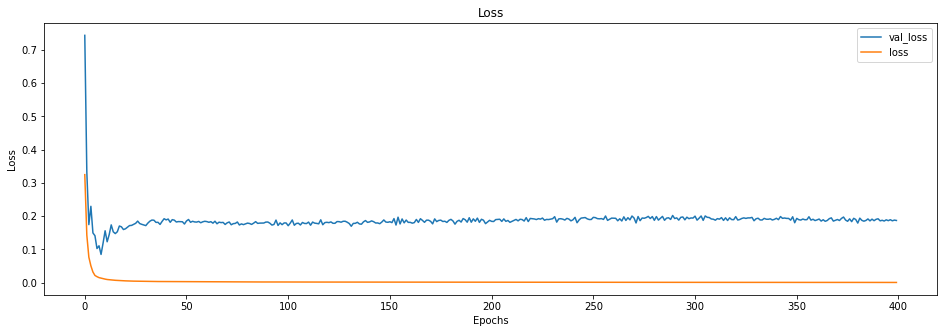

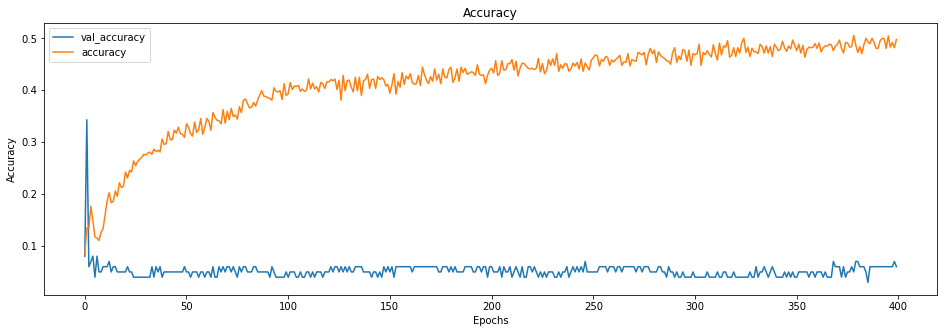

In [25]:
visualize_training_results(res)

RMSE: 6.552388578216615


ConversionError: Failed to convert value(s) to axis units: '2018-05'

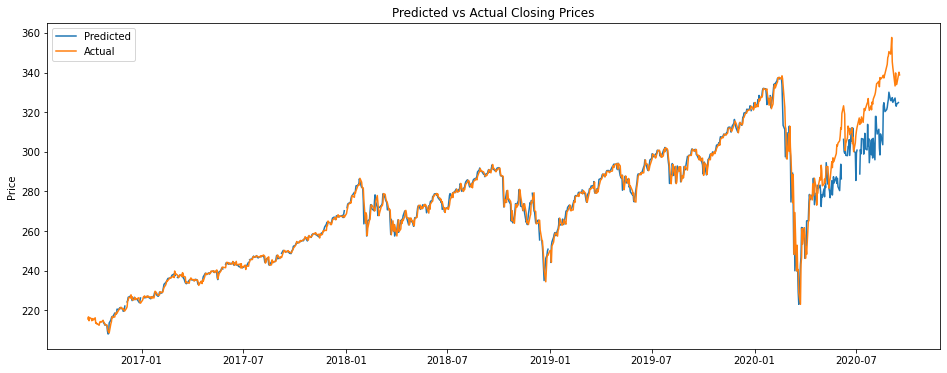

In [22]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(data_frame[["Close"]]), 
                      index=data_frame.index, 
                      columns=[data_frame.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validator(days_learn, days_predict)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.xlim('2018-05', '2020-05')
plt.show()

                 Close
2020-09-17  323.507477
2020-09-18  318.603119
2020-09-21  315.098969
2020-09-22  301.327209
2020-09-23  317.411438
2020-09-24  300.225861
2020-09-25  297.522858
2020-09-28  298.948303
2020-09-29  313.144287
2020-09-30  305.406769


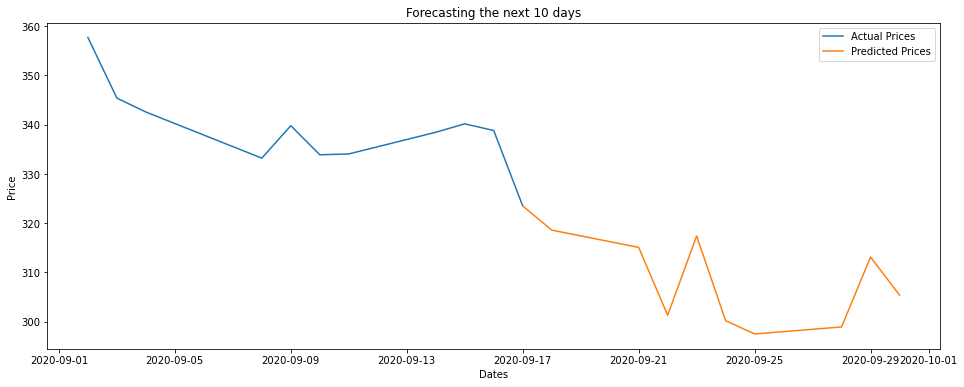

In [23]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(data_frame.tail(days_learn)).reshape(1, days_learn, features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=data_frame.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[data_frame.columns[0]])

# Number of periods back to plot the actual values
pers = days_learn

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(data_frame[["Close"]].tail(pers)), 
                      index=data_frame.Close.tail(pers).index, 
                      columns=[data_frame.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()